kept: ['id', 'flat_type', 'floor_area_sqm', 'flat_model', 'resale_price', 'hdb_age', 'planning_area', 'Mall_Nearest_Distance', 'Hawker_Nearest_Distance', 'mrt_nearest_distance', 'pri_sch_nearest_distance']

LinearRegression → R²: 0.839, RMSE: 57,536.1, MAPE: 10.58%

Top 20 Features by Permutation Importance:
                    feature  importance
             floor_area_sqm    0.584826
                    hdb_age    0.338954
  planning_area_Bukit Merah    0.162587
   planning_area_Queenstown    0.121607
       planning_area_Bishan    0.075396
    planning_area_Toa Payoh    0.073884
planning_area_Marine Parade    0.064812
   planning_area_Ang Mo Kio    0.055726
       mrt_nearest_distance    0.052502
        planning_area_Bedok    0.051122
    Hawker_Nearest_Distance    0.050017
      planning_area_Kallang    0.047954
     planning_area_Clementi    0.047572
      planning_area_Geylang    0.037626
    planning_area_Serangoon    0.033002
       planning_area_Outram    0.030231
     plann

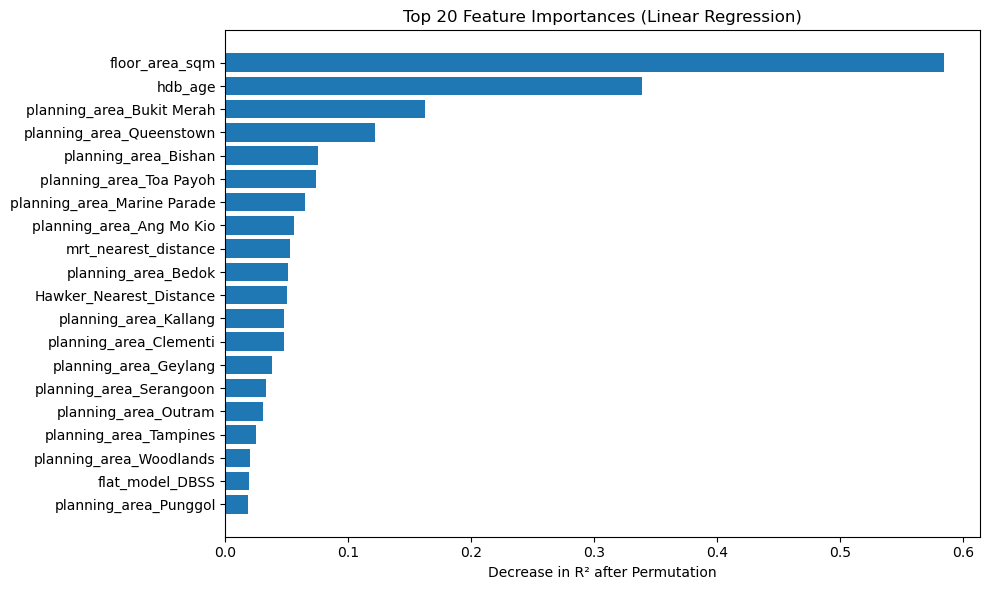

                           feature_transformed   coefficient     abs_coeff
0                          num__floor_area_sqm  77489.034235  77489.034235
1                                 num__hdb_age -58953.590585  58953.590585
2                   num__Mall_Nearest_Distance  -8886.034334   8886.034334
3                 num__Hawker_Nearest_Distance -22684.395150  22684.395150
4                    num__mrt_nearest_distance -23226.590210  23226.590210
5                num__pri_sch_nearest_distance   3093.586433   3093.586433
6                num__planning_area_Ang Mo Kio  23945.373063  23945.373063
7                     num__planning_area_Bedok  22871.200103  22871.200103
8                    num__planning_area_Bishan  27825.923750  27825.923750
9               num__planning_area_Bukit Batok  12221.099089  12221.099089
10              num__planning_area_Bukit Merah  40911.807415  40911.807415
11            num__planning_area_Bukit Panjang   -334.289984    334.289984
12              num__plan

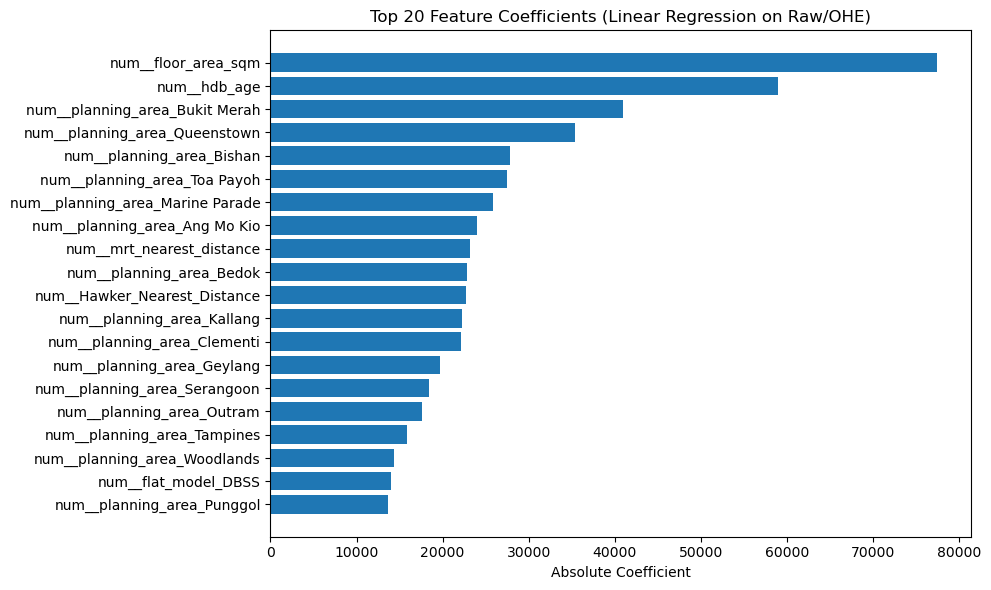

In [110]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder, LabelEncoder,
    StandardScaler, FunctionTransformer
)
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance


# —— CONFIGURATION ——
TRAIN_CSV = "./train_3.csv"

# 1) Read header & flag rows
with open(TRAIN_CSV, newline='', encoding='utf-8') as f:
    reader    = csv.reader(f)
    col_names = next(reader)
    flags     = next(reader)

# 2) Keep only flagged columns
col_names = [col.strip().replace('\ufeff', '') for col in col_names]
keep_cols = [c for c, flag in zip(col_names, flags) if flag.strip().lower()=='keep']
print(f'kept: {keep_cols}\n')
#print("")

# 3) Drop leakage/identifier fields
usecols  = [col for col in col_names if col not in keep_cols]
#print(f'not_kept: {not_kept_cols}')

# 4) Load data, skip flag row
df = pd.read_csv(
    TRAIN_CSV,
    header=0,
    skiprows=[1],
    usecols=keep_cols,
    engine='python'
)
id_col = df['id'] #pull out id from train/test of data set 

# 5) Clean target, require flat_type & flat_model

df['resale_price'] = pd.to_numeric(df['resale_price'], errors='coerce')
df.dropna(subset=['resale_price','flat_type','flat_model'], inplace=True)
df.reset_index(drop=True, inplace=True)

# 6a) Collapse rare flat_model into 'others'
df['flat_model'] = df['flat_model'].replace({
    'Adjoined flat':'others','Model A-Maisonette':'others','Type S1':'others',
    'Type S2':'others','Terrace':'others','Multi Generation':'others',
    'Premium Apartment Loft':'others','Improved-Maisonette':'others',
    'Premium Maisonette':'others','2-room':'others'
})

# 6b) Collapse rare flat_type into 'others'
df['flat_type'] = df['flat_type'].replace({
    '2 ROOM':'others','1 ROOM':'others','MULTI-GENERATION':'others'
})
df_encoded = pd.get_dummies(df[['planning_area','flat_model','flat_type']], dtype=int)
#print(df_encoded.columns.tolist())
dummy_counts = df_encoded.sum().sort_values(ascending=False).reset_index()
dummy_counts.columns = ['Category', 'Count']
#print(dummy_counts)
df_encoded = df_encoded.drop(columns=['flat_type_4 ROOM','flat_model_Model A','planning_area_Jurong West'])

# Drop original categorical columns from the main df
df = df.drop(columns=['planning_area', 'flat_model', 'flat_type'])


# Concatenate the encoded columns back to the main df
df = pd.concat([df, df_encoded], axis=1)

# 9) Split into features/target
X = df.drop(columns=['resale_price','id'])
y = df['resale_price'].astype(float)

# 10) Identify numeric vs categorical
numeric_feats = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_feats = X.select_dtypes(include=['object','bool']).columns.tolist()
#print(f'numeric: {numeric_feats}\n')
#print(f'categorical: {categorical_feats}\n')

# 12) Preprocessing: impute + scale numeric, one-hot categorize
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler()) 
])
categorical_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe',    OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_feats),
])

# 13) Train/test split
#X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
#    X, y, id_col,
#    test_size=0.2,
#    random_state=42
#)

# 15) Build pure linear regression pipeline with log-target
lr_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('model',   LinearRegression())
])
ttr = TransformedTargetRegressor(
    regressor=lr_pipeline,
    #transformer=FunctionTransformer(np.log1p, np.expm1, validate=False)
)

# 16) Fit the model
ttr.fit(X, y)

# 17) Predict & evaluate
preds = ttr.predict(X)
r2   = r2_score(y, preds)
rmse = np.sqrt(mean_squared_error(y, preds))
mape = mean_absolute_percentage_error(y, preds) * 100
print(f"LinearRegression → R²: {r2:.3f}, RMSE: {rmse:,.1f}, MAPE: {mape:.2f}%")

# 18) Permutation importance on original features
class ModelWrapper:
    def __init__(self, model): self.model = model
    def fit(self, X, y): return self
    def predict(self, X): return self.model.predict(X)

wrapper = ModelWrapper(ttr)
perm = permutation_importance(
    wrapper, X, y,
    n_repeats=10, random_state=42, n_jobs=-1, scoring='r2'
)

# 19) Display top 20 perm importances
feat_names = X.columns.tolist()
imp_df = pd.DataFrame({
    'feature': feat_names,
    'importance': perm.importances_mean
}).sort_values('importance', ascending=False)
top20 = imp_df.head(20)
print("\nTop 20 Features by Permutation Importance:")
print(top20.to_string(index=False))

plt.figure(figsize=(10,6))
plt.barh(top20['feature'][::-1], top20['importance'][::-1])
plt.xlabel('Decrease in R² after Permutation')
plt.title('Top 20 Feature Importances (Linear Regression)')
plt.tight_layout()
plt.show()

# 20) Display top 20 transformed feature coefficients
fitted_preproc = ttr.regressor_.named_steps['preproc']

intercept_y = ttr.regressor_.named_steps['model'].intercept_

transformed_feats = fitted_preproc.get_feature_names_out()
coefs = ttr.regressor_.named_steps['model'].coef_
coef_df = pd.DataFrame({
    'feature_transformed': transformed_feats,
    'coefficient': coefs,
})
coef_df['abs_coeff'] = coef_df['coefficient'].abs()
print(coef_df)

top_coef = coef_df.sort_values('abs_coeff', ascending=False).head(20)

print(f'Intercept: {intercept_y}\n')
print("\nTop 20 Transformed Features by |Coefficient|:")
print(top_coef[['feature_transformed','coefficient']].to_string(index=False))

plt.figure(figsize=(10,6))
plt.barh(top_coef['feature_transformed'][::-1], top_coef['abs_coeff'][::-1])
plt.xlabel('Absolute Coefficient')
plt.title('Top 20 Feature Coefficients (Linear Regression on Raw/OHE)')
plt.tight_layout()
plt.show()

# Path to the new CSV file to predict on
NEW_CSV = "./test_data.csv"
#print(keep_cols)
#keep_cols_id = [col for col in col_names if col not in keep_cols]

keep_cols_id= keep_cols.remove('resale_price')
# Load new data with the same columns as training features

new_df = pd.read_csv(
    NEW_CSV,
    usecols=keep_cols_id,  # use the same features as in training
    engine='python'
)

id_test_col = new_df['id'] 

# (Optional) Handle missing columns or preprocess if needed here
# For example, make sure categorical columns exist and match training

# Predict resale price on new data using the trained pipeline
#new_df['Remaining'] = 99 - new_df['hdb_age']
#new_df = new_df.drop(columns=['hdb_age'])
new_df = new_df.drop(columns='id')
new_df['flat_model'] = new_df['flat_model'].replace({
    'Adjoined flat':'others','Model A-Maisonette':'others','Type S1':'others',
    'Type S2':'others','Terrace':'others','Multi Generation':'others',
    'Premium Apartment Loft':'others','Improved-Maisonette':'others',
    'Premium Maisonette':'others','2-room':'others'
})

# 6b) Collapse rare flat_type into 'others'
new_df['flat_type'] = new_df['flat_type'].replace({
    '2 ROOM':'others','1 ROOM':'others','MULTI-GENERATION':'others'
})

new_df_encoded = pd.get_dummies(new_df[['planning_area','flat_model','flat_type']], dtype=int)
new_df_encoded = new_df_encoded.drop(columns=['flat_type_4 ROOM','flat_model_Model A','planning_area_Jurong West'])
#print(new_df_encoded)
new_df = new_df.drop(columns=['planning_area', 'flat_model', 'flat_type'])

# Concatenate the encoded columns back to the main df
new_df = pd.concat([new_df, new_df_encoded], axis=1)
new_preds = ttr.predict(new_df)

#new_df['id'] = id_column.loc[new_df.index].values

# Add predictions to new_df
new_df['Predicted_Resale_Price'] = new_preds
new_df['id'] = id_test_col.values


# (Optional) Save predictions to CSV
new_df.to_csv("new_data_with_predictions.csv", index=False)

In [ ]:
#merge data sets 
import pandas as pd

# Load the CSV files
df1 = pd.read_csv("./new_data_with_predictions.csv")  # e.g., main dataset
df2 = pd.read_csv("./test_data.csv", low_memory = False)  # e.g., predictions or supplementary info
df3 = pd.read_csv("./train_data_set.csv", low_memory = False)

df1_subset = df1[['id', 'Predicted_Resale_Price']]
#print(df1_subset.shape)
#print(df2.shape)

# Perform an inner merge on the 'id' column
merged_df = pd.merge(df2, df1_subset, on='id', how='inner')


cols = list(merged_df.columns)
col_to_move = cols[77]
cols.pop(77)
#print(col_to_move)
cols.insert(10, col_to_move)
merged_df = merged_df[cols]

merged_df = merged_df.rename(columns={col_to_move: 'resale_price'})
print(merged_df.columns[10])

combined_df = pd.concat([df3, merged_df], ignore_index = True)

# Save to new CSV
merged_df.to_csv("merged_test_data.csv", index=False)
#print(merged_df)
combined_df.to_csv("final_dataset.csv", index=False)
print("File save completed")